In [1]:
pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the expert and crowd annotations data
expert_annotations_path = '/content/drive/My Drive/ExpertAnnotations.tsv'
crowd_annotations_path = '/content/drive/My Drive/CrowdAnnotations.tsv'

In [5]:
# Read the data
expert_annotations_df = pd.read_csv(expert_annotations_path, sep='\t', header=None)
crowd_annotations_df = pd.read_csv(crowd_annotations_path, sep='\t', header=None)

***Переименуем безымянные названия столбцов чтобы в дальнейшем было удобно по ним обьединить нужные столбцы в единый обучающий датасет.***

In [6]:
# Naming the columns of the CrowdAnnotations.tsv file as per the description given
crowd_annotations_df.columns = [
    'Image file name',
    'Description ID',
    'Percentage of matches',
    'Number of confirmations',
    'Number of rejections'
]

# Naming the columns of the ExpertAnnotations.tsv file as per the description given
expert_annotations_df.columns = [
    'Image file name',
    'Description ID',
    'Expert 1 rating',
    'Expert 2 rating',
    'Expert 3 rating'
]

print(expert_annotations_df.head(10))
print()
print(crowd_annotations_df.head(10))

             Image file name               Description ID  Expert 1 rating  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2                1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2                1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2                1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2                1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2                1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2                1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2                1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2                1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2                2   

   Expert 2 rating  Expert 3 rating  
0                1                1  
1                1                2  
2                1         

In [7]:
print(expert_annotations_df.info())
print()
print(crowd_annotations_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Image file name  5822 non-null   object
 1   Description ID   5822 non-null   object
 2   Expert 1 rating  5822 non-null   int64 
 3   Expert 2 rating  5822 non-null   int64 
 4   Expert 3 rating  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          47830 non-null  object 
 1   Description ID           47830 non-null  object 
 2   Percentage of matches    47830 non-null  float64
 3   Number of confirmations  47830 non-null  int64  
 4   Number of rejections     47830 non-null  int64  
dtypes: float64(1), int64(2), objec

In [8]:
# To explore the correlation between expert and crowd annotations, we need to prepare the data accordingly.
# We'll convert expert ratings to a 0-1 scale to match the crowd percentage scale.
# Then, we'll calculate the mean expert rating and compare it with the crowd percentage.

# First, normalize the expert ratings to a 0-1 scale
expert_annotations_df['Normalized Expert 1'] = expert_annotations_df['Expert 1 rating'] / 4
expert_annotations_df['Normalized Expert 2'] = expert_annotations_df['Expert 2 rating'] / 4
expert_annotations_df['Normalized Expert 3'] = expert_annotations_df['Expert 3 rating'] / 4

# Calculate the mean expert rating
expert_annotations_df['Mean Expert Rating'] = expert_annotations_df[
    ['Normalized Expert 1', 'Normalized Expert 2', 'Normalized Expert 3']].mean(axis=1)

# For the crowd annotations, we assume 'Percentage of matches' is already on a 0-1 scale, so we use it directly.

# Next, we need to join the two dataframes to compare the ratings. We'll do this on 'Image file name' and 'Description ID'.
merged_annotations = pd.merge(
    crowd_annotations_df,
    expert_annotations_df,
    how='inner',
    on=['Image file name', 'Description ID']
)

# Now let's calculate the correlation between the crowd's percentage and the mean expert rating.
correlation = merged_annotations['Percentage of matches'].corr(merged_annotations['Mean Expert Rating'])
correlation

0.7907823667086611

In [9]:
# Assigning weights to expert and crowd scores
expert_weight = 0.6
crowd_weight = 0.4

# Ensure the crowd's 'Percentage of matches' is in a 0-1 range
# Note: This is already the case as per the dataset description, but we include this step for completeness
merged_annotations['Normalized Crowd Percentage'] = merged_annotations['Percentage of matches']

# Compute the weighted combined score using the assigned weights
merged_annotations['Weighted Combined Score'] = (
    (merged_annotations['Mean Expert Rating'] * expert_weight) +
    (merged_annotations['Normalized Crowd Percentage'] * crowd_weight)
)

# Check the first few rows to ensure the combined score is computed correctly
merged_annotations[['Image file name', 'Description ID', 'Normalized Crowd Percentage', 'Mean Expert Rating', 'Weighted Combined Score']].head()

,Image file name,Description ID,Normalized Crowd Percentage,Mean Expert Rating,Weighted Combined Score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.250000,0.150000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000,0.333333,0.200000
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,0.333333,0.200000
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.000000,0.500000,0.300000
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.333333,0.666667,0.533333


In [10]:
# Selecting only the required columns: 'Image file name', 'Description ID', 'Weighted Combined Score'
# and assigning it to the variable train_df
annotations_df = merged_annotations[['Image file name', 'Description ID', 'Weighted Combined Score']]

# Displaying the first few rows of train_df to verify
annotations_df.head()

,Image file name,Description ID,Weighted Combined Score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.150000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.200000
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.200000
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.300000
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.533333


In [11]:
annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          2329 non-null   object 
 1   Description ID           2329 non-null   object 
 2   Weighted Combined Score  2329 non-null   float64
dtypes: float64(1), object(2)
memory usage: 72.8+ KB


In [12]:
# To understand the reduction in entries, we will examine the coverage and consistency of 'Image file name' and 'Description ID'
# in both the crowd and expert annotations dataframes.

# Count of unique 'Image file name' and 'Description ID' in both datasets
unique_crowd_images = crowd_annotations_df['Image file name'].nunique()
unique_expert_images = expert_annotations_df['Image file name'].nunique()
unique_crowd_descriptions = crowd_annotations_df['Description ID'].nunique()
unique_expert_descriptions = expert_annotations_df['Description ID'].nunique()

# Checking for any discrepancies in formatting or matching issues
# We will look at the intersections of the sets of unique identifiers to see how many are shared.
shared_image_files = set(crowd_annotations_df['Image file name']).intersection(set(expert_annotations_df['Image file name']))
shared_description_ids = set(crowd_annotations_df['Description ID']).intersection(set(expert_annotations_df['Description ID']))

# Calculate the number of shared identifiers
num_shared_image_files = len(shared_image_files)
num_shared_description_ids = len(shared_description_ids)

unique_crowd_images, unique_expert_images, unique_crowd_descriptions, unique_expert_descriptions, num_shared_image_files, num_shared_description_ids

(1000, 1000, 1000, 977, 1000, 977)

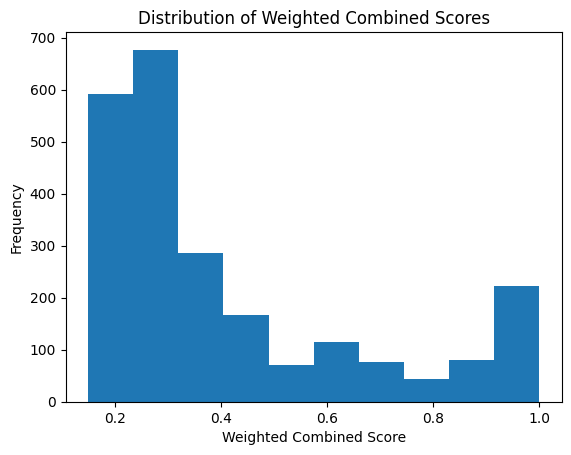

(count    2329.000000
 mean        0.410635
 std         0.260245
 min         0.150000
 25%         0.200000
 50%         0.300000
 75%         0.533333
 max         1.000000
 Name: Weighted Combined Score, dtype: float64,
 891,
 766)

In [13]:
# 1. Distribution of Weighted Combined Score
score_description = annotations_df['Weighted Combined Score'].describe()
score_histogram = annotations_df['Weighted Combined Score'].hist()
plt.title('Distribution of Weighted Combined Scores')
plt.xlabel('Weighted Combined Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# 2. Diversity of Images
unique_images = annotations_df['Image file name'].nunique()

# 3. Diversity of Descriptions
unique_descriptions = annotations_df['Description ID'].nunique()

score_description, unique_images, unique_descriptions

# Проверка данных

In [14]:
# Load the dataset
file_path = '/content/drive/My Drive/train_dataset.csv'
train_dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset and its basic info
print(train_dataset.info())
print()
print(train_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A

In [15]:
# Step 1: Define a list of restricted keywords (examples based on the context provided)
restricted_keywords = ['minor', "child", "children", "toddlers",
                       "kid", "boy", "girl", "school", "playground"]
  # This list should be expanded based on legal advice

# Step 2: Function to check if the description contains any restricted keyword
def contains_restricted_keyword(text, keywords):
    text = text.lower()  # Convert to lower case for case insensitive matching
    return any(keyword in text for keyword in keywords)

# Step 3: Filter out entries with restricted content
train_dataset['contains_restricted'] = train_dataset['query_text'].apply(lambda x: contains_restricted_keyword(x, restricted_keywords))
filtered_train_df = train_dataset[~train_dataset['contains_restricted']]

# Display the impact of filtering
original_count = len(train_dataset)
filtered_count = len(filtered_train_df)
original_count, filtered_count, filtered_train_df.head()

(5822,
 4318,
                         image                     query_id  \
 22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
 23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
 24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
 25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
 26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
 
                                          query_text  contains_restricted  
 22  A man sleeps under a blanket on a city street .                False  
 23  A man sleeps under a blanket on a city street .                False  
 24  A man sleeps under a blanket on a city street .                False  
 25  A man sleeps under a blanket on a city street .                False  
 26  A man sleeps under a blanket on a city street .                False  )

In [16]:
filtered_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4318 entries, 22 to 5821
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                4318 non-null   object
 1   query_id             4318 non-null   object
 2   query_text           4318 non-null   object
 3   contains_restricted  4318 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 139.2+ KB


In [17]:
# Step 1: Rename columns in filtered_train_df to align with annotations_df
filtered_train_df.rename(columns={'image': 'Image file name', 'query_id': 'Description ID'}, inplace=True)

# Step 2: Merge annotations_df with filtered_train_df
pre_train_df = pd.merge(annotations_df, filtered_train_df, on=['Image file name', 'Description ID'])

# Verifying the result
print(pre_train_df.info())
print()
print(pre_train_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          1811 non-null   object 
 1   Description ID           1811 non-null   object 
 2   Weighted Combined Score  1811 non-null   float64
 3   query_text               1811 non-null   object 
 4   contains_restricted      1811 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 72.5+ KB
None

                Image file name               Description ID  \
0     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
1     1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2   
2     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2   
3     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2   
4     1096395242_fc69f0ae5a.jpg  1425069308_488e5fcf9d.jpg#2   
...                         ...                          ...   


<ipython-input-17-aedde2c084df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df.rename(columns={'image': 'Image file name', 'query_id': 'Description ID'}, inplace=True)


In [18]:
pre_train_df = pre_train_df[['Image file name', 'Description ID',
                             'query_text', 'Weighted Combined Score']]
print(pre_train_df.info())
print()
print(pre_train_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          1811 non-null   object 
 1   Description ID           1811 non-null   object 
 2   query_text               1811 non-null   object 
 3   Weighted Combined Score  1811 non-null   float64
dtypes: float64(1), object(3)
memory usage: 70.7+ KB
None

                Image file name               Description ID  \
0     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
1     1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2   
2     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2   
3     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2   
4     1096395242_fc69f0ae5a.jpg  1425069308_488e5fcf9d.jpg#2   
...                         ...                          ...   
1806    96420612_feb18fc6c6.jpg  3541474181_489f19fae7.jpg#2   

Файл train_dataset.csv содержит 5822 записи и состоит из трех столбцов:

- **ImageID**: этот столбец содержит имена файлов изображений.
- **DescriptionID**: этот столбец имеет уникальный идентификатор для каждого описания в формате <имя файла изображения>#<порядковый номер описания>.
- **query_text**: этот столбец содержит текстовое описание, связанное с каждым изображением.

Из первых нескольких строк очевидно, что несколько строк могут относиться к одному и тому же изображению, но с разными описаниями, или одно и то же описание может повторяться на разных изображениях.

Учитывая поставленную задачу, значительная часть очистки данных будет включать проверку столбца query_text на предмет любых признаков ограниченного контента, особенно описаний с участием детей до 16 лет. Нам нужно будет составить список ключевых слов, которые, вероятно, являются индикаторами такого контента, и отфильтровать все строки, соответствующие этим критериям.

Давайте предположим, что это упрощенный список ключевых слов, которые могут быть связаны с детьми. В реальном сценарии нам нужен более полный и конфиденциальный список, возможно, проверенный командой юристов.

Примеры ключевых слов: ["child", "children", "kid", "boy", "girl", "school", "playground"]

Затем мы отфильтруем описания с помощью ключевых слов. Мы пройдемся по столбцу query_text и удалим все строки, содержащие эти ключевые слова. Этот процесс можно усовершенствовать с помощью регулярного выражения для более детального сопоставления.

Процесс фильтрации на основе ключевых слов сократил набор данных с 5822 записей до 4321 записи. Это означает, что 1501 запись была удалена, поскольку они, вероятно, содержали ссылки на детей или связанные контексты.

Это базовый подход и, вероятно, не исчерпывающий. Он служит отправной точкой, и в реальном приложении потребуется более детальный и всеобъемлющий процесс фильтрации, возможно, с использованием более сложных методов обработки естественного языка и более тщательного списка ключевых слов.

# Векторизация текстов

In [19]:
# Function to encode text using BERT with GPU
def bert_encode(text, model, tokenizer, device):
    # Tokenize input text (add special tokens and convert to IDs)
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)  # Send to GPU

    # Get the output (last hidden states) from the BERT model
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # The first tuple of the output is the last hidden state

    # Move the result back to CPU and convert to numpy
    return last_hidden_states[0][0].cpu().numpy()

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained model tokenizer and model, and send the model to GPU
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Vectorize the text descriptions
pre_train_df['bert_vector'] = pre_train_df['query_text'].apply(lambda x: bert_encode(x, model, tokenizer, device))

# Note: This is a simplified example. Depending on your specific requirements and dataset size,
# you may need to batch the texts and manage memory usage more efficiently.


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
pre_train_df.head()

,Image file name,Description ID,query_text,Weighted Combined Score,bert_vector
0,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.200000,"[0.20837602, 0.19895823, 0.058023393, -0.02440..."
1,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,0.300000,"[-0.014534058, -0.039590366, -0.2054309, 0.139..."
2,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,Close-up of dog in profile with mouth open .,0.533333,"[-0.78212327, -0.5189205, -0.44774392, 0.03597..."
3,1084040636_97d9633581.jpg,3396157719_6807d52a81.jpg#2,A dog gets on a trampoline .,0.250000,"[-0.17570308, 0.104248144, -0.6895283, 0.16900..."
4,1096395242_fc69f0ae5a.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,0.300000,"[-0.36722273, 0.01828046, -0.89691925, 0.20806..."


In [22]:
pre_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          1811 non-null   object 
 1   Description ID           1811 non-null   object 
 2   query_text               1811 non-null   object 
 3   Weighted Combined Score  1811 non-null   float64
 4   bert_vector              1811 non-null   object 
dtypes: float64(1), object(4)
memory usage: 84.9+ KB


Чтобы векторизировать тексты с помощью BERT из Hugging Face Transformers, были выполнены следующие действия:

1. **Настройка среды**: установлена необходимая библиотека из Hugging Face - transformers.
2. **Загрузка предварительно обученной модели BERT и токенизатора**: Использована предварительно обученная модель BERT, подходящая для наших нужд, вместе с соответствующим токенизатором.
3. **Предварительная обработка и токенизация текста**: Подготовлены текстовые данные для модели, включая их токенизацию и правильное форматирование.
4. **Генерация эмбеддингов**: токенизированный текст был передан модели, чтобы получить эмбеддинги - числовые векторы.

# Векторизация изображений

In [28]:
# Ensure TensorFlow uses GPU (if available)
tf.device('/device:GPU:0')

# Load the ResNet50 model pre-trained on ImageNet data (silently)
tf.get_logger().setLevel('ERROR')  # Set TensorFlow logging level to reduce verbosity
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to convert images to vectors using ResNet50
def resnet50_encode(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load and resize the image
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_preprocessed = preprocess_input(img_array_expanded)  # Preprocess the image

    # Get features (silently)
    features = model.predict(img_preprocessed, verbose=0)  # Set verbose=0 to silence the model prediction
    return features.flatten()  # Flatten the features

# Directory containing images
image_dir = '/content/drive/My Drive/train_images'

# Initialize a list to hold image file names and their corresponding vectors
image_data = []
# Loop through the directory and process each image
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    if os.path.isfile(img_path):  # Making sure it's a file, not a subdirectory
        img_vector = resnet50_encode(img_path)
        image_data.append({'Image file name': img_name, 'resnet50_vector': img_vector})

# Convert the list of dictionaries to a DataFrame
image_vectors_df = pd.DataFrame(image_data)
image_vectors_df

,Image file name,resnet50_vector
0,510531976_90bbee22a2.jpg,"[0.27306557, 0.7899623, 0.03319925, 1.2073627,..."
1,2762301555_48a0d0aa24.jpg,"[0.4480564, 1.0786641, 0.18887384, 0.9539038, ..."
2,300314926_0b2e4b64f5.jpg,"[0.7242572, 0.20963274, 0.099216335, 0.0076660..."
3,3286822339_5535af6b93.jpg,"[0.3958953, 1.1315533, 0.0047899596, 0.4610124..."
4,3502343542_f9b46688e5.jpg,"[0.35710073, 1.143127, 0.46283185, 0.0, 0.0, 0..."
...,...,...
995,3108197858_441ff38565.jpg,"[0.46488023, 0.8818283, 0.11253191, 3.759429, ..."
996,3397220683_4aca010f86.jpg,"[1.552202, 3.1731007, 0.28125498, 0.2180369, 0..."
997,1224851143_33bcdd299c.jpg,"[0.6418191, 0.1550817, 0.6333874, 2.7627277, 0..."
998,2351479551_e8820a1ff3.jpg,"[0.09802001, 0.008783078, 0.038294923, 0.36819..."


In [29]:
image_vectors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Image file name  1000 non-null   object
 1   resnet50_vector  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [30]:
# Merging pre_train_df with image_vectors_df on 'Image file name'
final_train_df = pd.merge(pre_train_df, image_vectors_df, on='Image file name')
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image file name          1811 non-null   object 
 1   Description ID           1811 non-null   object 
 2   query_text               1811 non-null   object 
 3   Weighted Combined Score  1811 non-null   float64
 4   bert_vector              1811 non-null   object 
 5   resnet50_vector          1811 non-null   object 
dtypes: float64(1), object(5)
memory usage: 99.0+ KB


In [31]:
final_train_df.head()

,Image file name,Description ID,query_text,Weighted Combined Score,bert_vector,resnet50_vector
0,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.200000,"[0.20837602, 0.19895823, 0.058023393, -0.02440...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."
1,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,0.300000,"[-0.014534058, -0.039590366, -0.2054309, 0.139...","[0.03160423, 0.05835901, 0.15788616, 0.3648501..."
2,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,Close-up of dog in profile with mouth open .,0.533333,"[-0.78212327, -0.5189205, -0.44774392, 0.03597...","[0.23355141, 0.24799334, 0.25204146, 0.0884625..."
3,1084040636_97d9633581.jpg,3396157719_6807d52a81.jpg#2,A dog gets on a trampoline .,0.250000,"[-0.17570308, 0.104248144, -0.6895283, 0.16900...","[0.23355141, 0.24799334, 0.25204146, 0.0884625..."
4,1096395242_fc69f0ae5a.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,0.300000,"[-0.36722273, 0.01828046, -0.89691925, 0.20806...","[0.38449508, 0.32468647, 0.0, 1.333906, 1.1282..."


In [32]:
final_train_df = final_train_df[['bert_vector', 'resnet50_vector', 'Weighted Combined Score']]
final_train_df.head()

,bert_vector,resnet50_vector,Weighted Combined Score
0,"[0.20837602, 0.19895823, 0.058023393, -0.02440...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0...",0.200000
1,"[-0.014534058, -0.039590366, -0.2054309, 0.139...","[0.03160423, 0.05835901, 0.15788616, 0.3648501...",0.300000
2,"[-0.78212327, -0.5189205, -0.44774392, 0.03597...","[0.23355141, 0.24799334, 0.25204146, 0.0884625...",0.533333
3,"[-0.17570308, 0.104248144, -0.6895283, 0.16900...","[0.23355141, 0.24799334, 0.25204146, 0.0884625...",0.250000
4,"[-0.36722273, 0.01828046, -0.89691925, 0.20806...","[0.38449508, 0.32468647, 0.0, 1.333906, 1.1282...",0.300000
